# Chatbots with Hugging Face - 2025

## The Libraries

Load some libraries:

In [1]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel
from transformers import logging as transformers_logging
from datasets import load_dataset, Dataset, concatenate_datasets
from torchinfo import summary
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import transformers
import datasets
import torch
import numpy
import json
import random
import warnings
import logging

In [2]:
from platform import python_version
print("Python:", python_version())
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("numpy:", np.__version__)

Python: 3.10.14
torch: 2.3.0
transformers: 4.40.2
datasets: 2.19.1
numpy: 1.26.4


The paths to the directories to load and save datasets and models:

In [3]:
platform = "laptop" # possible choices are "jupyter", "laptop" and "curnagl"

if platform == "jupyter":
    PATH_DATASETS = "./Datasets/"
    PATH_MODELS = "./Models/"
    PATH_RESULTS = "./Results/"
    
elif platform == "laptop":
    PATH_DATASETS = "./Datasets/"
    PATH_MODELS = "./Models/"
    PATH_RESULTS = "./Results/"
    
elif platform == "curnagl":
    PATH_DATASETS = "/users/klleshi/LLMProject/chatbot"
    PATH_MODELS = "/users/klleshi/LLMProject/chatbot"
    PATH_RESULTS = "/users/klleshi/LLMProject/chatbot"

Try to use GPUs if available:

In [4]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: mps


Suppress some specific logging and warnings from transformers and Hugging Face Hub modules:

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
transformers_logging.set_verbosity_error()

To make the whole pipeline reproducible:

In [6]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
transformers.set_seed(seed)

# The dataset

We are going to use the Multi-Domain Wizard-of-Oz dataset (MultiWOZ). This is a fully-labeled collection of human-human written conversations spanning over multiple domains and topics. See https://huggingface.co/datasets/pfb30/multi_woz_v22 and https://arxiv.org/abs/1810.00278.

Load the "MultiWOZ" dataset:

In [7]:
dataset = load_dataset('multi_woz_v22', trust_remote_code=True)

Look at the dataset:

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 8437
    })
    validation: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
})

Look at an example:

In [9]:
example = dataset['train'][0]
print(example)

{'dialogue_id': 'PMUL4398.json', 'services': ['restaurant', 'hotel'], 'turns': {'turn_id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 'utterance': ['i need a place to dine in the center thats expensive', 'I have several options for you; do you prefer African, Asian, or British food?', 'Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?', 'There is an Afrian place named Bedouin in the centre. How does that sound?', 'Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?', "Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town.", 'Yes. Can you book it for me?', 'Sure, when would you like that reservation?', 'i want to book it for 2 people and 2 nights starting from saturday.', 'Your booking was successful. Your reference number is FRGZWQL2 . May I help you

Format it as a dialogue:

In [10]:
dialogue = example["turns"]

for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
    if speaker == 0:  # User input
        print(f" [USER] {utterance.strip()} ")
    elif speaker == 1:  # System response
        print(f" [BOT] {utterance.strip()}")

 [USER] i need a place to dine in the center thats expensive 
 [BOT] I have several options for you; do you prefer African, Asian, or British food?
 [USER] Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? 
 [BOT] There is an Afrian place named Bedouin in the centre. How does that sound?
 [USER] Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? 
 [BOT] Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town.
 [USER] Yes. Can you book it for me? 
 [BOT] Sure, when would you like that reservation?
 [USER] i want to book it for 2 people and 2 nights starting from saturday. 
 [BOT] Your booking was successful. Your reference number is FRGZWQL2 . May I help you further?
 [USER] That is all I need to know. Thanks, good bye. 
 [BOT] Thank you so much for Cambridge TownInfo centre. Have a great day!


Add the special token "<|endoftext|>" at the end of each diologue:

In [11]:
examples = dataset['train'].select(range(2))

dialogues = []
for dialogue in examples['turns']:
    dialogue_text = ""
    for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
        if speaker == 0:  # User input
            dialogue_text += f"[USER] {utterance.strip()} "
        elif speaker == 1:  # System response
            dialogue_text += f"[BOT] {utterance.strip()} "
    dialogues.append(dialogue_text + "<|endoftext|>")

print(dialogues)

["[USER] i need a place to dine in the center thats expensive [BOT] I have several options for you; do you prefer African, Asian, or British food? [USER] Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? [BOT] There is an Afrian place named Bedouin in the centre. How does that sound? [USER] Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? [BOT] Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town. [USER] Yes. Can you book it for me? [BOT] Sure, when would you like that reservation? [USER] i want to book it for 2 people and 2 nights starting from saturday. [BOT] Your booking was successful. Your reference number is FRGZWQL2 . May I help you further? [USER] That is all I need to know. Thanks, good bye. [BOT] Thank you so much for Cambridge TownInfo centre. Have a great day! <|endoftext|>", "[USER] Guten Tag, I am sta

Load the pre-trained GPT-2 tokenizer and add special tokens:

In [12]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens_dict = {'additional_special_tokens': ['[USER]', '[BOT]'], 'pad_token': '[PAD]'}
tokenizer.add_special_tokens(special_tokens_dict)

3

Here the special tokens '[USER]' and '[BOT]' help GPT-2 to differentiate between different speakers in a conversation, facilitating the model’s ability to learn how a dialogue typically unfolds. By labeling input text with '[USER]' for the human’s part of the conversation and '[BOT]' for the chatbot’s response, you give the model a clear format. This will help it understand conversational roles and can also improve the training of dialogue models. GPT-2 will learn the conversational flow, that is the back-and-forth nature of conversation, and be able to generate coherent dialogue after training. In summary, GPT-2 will generate next words in such a way to mimic a conversation.

Analyse the dataset:

In [13]:
examples = dataset['train']

dialogues = []
for dialogue in examples['turns']:
    dialogue_text = ""
    for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
        if speaker == 0:  # User input
            dialogue_text += f"[USER] {utterance.strip()} "
        elif speaker == 1:  # System response
            dialogue_text += f"[BOT] {utterance.strip()} "
    dialogues.append(dialogue_text + "<|endoftext|>")

In [14]:
print("The number of dialogues in the dataset: ", len(dialogues))

The number of dialogues in the dataset:  8437


Plot a histogram of the number of tokens in each dialogue:

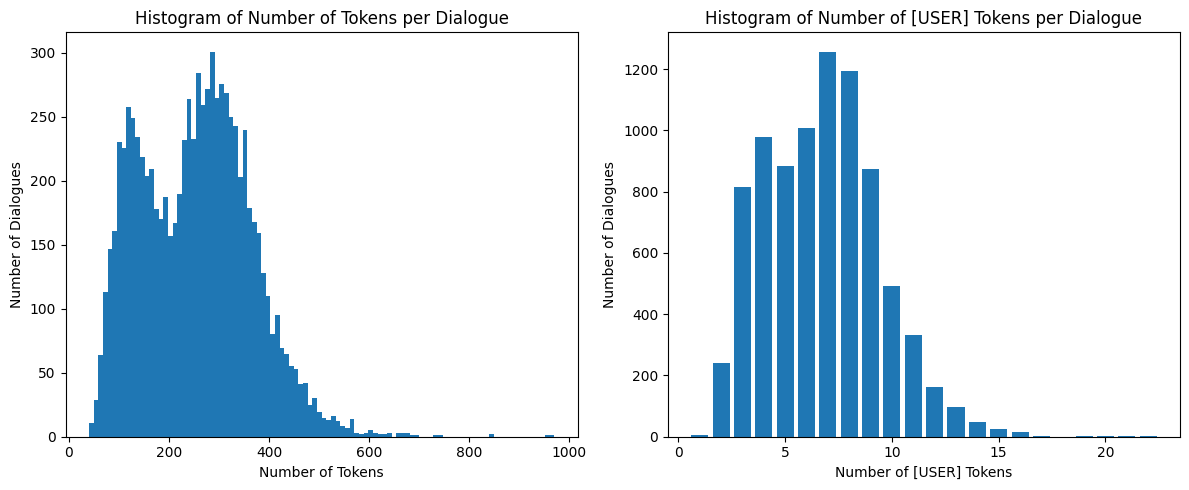

In [15]:
def plot_token_histogram(dialogues, tokenizer, num_bins=10):

    # Tokenizing the dialogues and counting tokens in each dialogue
    num_tokens_per_dialogue = [len(tokenizer.tokenize(dialogue)) for dialogue in dialogues]

    # Create histogram bins
    token_min = min(num_tokens_per_dialogue)
    token_max = max(num_tokens_per_dialogue)
    bins = np.linspace(token_min, token_max, num_bins + 1)  # Create `num_bins` equally spaced bins

    # Count occurrences of each token count
    token_counts, _ = np.histogram(num_tokens_per_dialogue, bins=bins)

    # Count occurrences of [USER] in each dialogue
    num_user_tokens_per_dialogue = [dialogue.count('[USER]') for dialogue in dialogues]
    user_token_counts = Counter(num_user_tokens_per_dialogue)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the histogram of token counts using bins
    axs[0].bar(bins[:-1], token_counts, width=np.diff(bins), align='edge')  # Plot with bins
    axs[0].set_xlabel('Number of Tokens')
    axs[0].set_ylabel('Number of Dialogues')
    axs[0].set_title('Histogram of Number of Tokens per Dialogue')

    # Plot the histogram of [USER] token counts
    axs[1].bar(user_token_counts.keys(), user_token_counts.values())
    axs[1].set_xlabel('Number of [USER] Tokens')
    axs[1].set_ylabel('Number of Dialogues')
    axs[1].set_title('Histogram of Number of [USER] Tokens per Dialogue')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_token_histogram(dialogues, tokenizer, num_bins=100)

Prepare the data in a dialogue format with maximum 512 tokens per conversation (this number may be increased to allow longer conversations) and maximum 12 user-bot exchanges per conversation. 

Terminology:
- 1 turn = 1 message (either from the user or the bot)
- 1 user-bot exchange = 2-turn conversation (1 message from the user followed by 1 message from the bot)

In [16]:
def preprocess_data_balanced(examples, max_context_exchanges=12):
    """
    This function processes dialogues and generates a balanced mix of single-turn and multi-turn conversations.
    Handles up to 12 user-bot exchanges (24 turns) in conversations within 512 tokens, ensuring efficient use of context.

    Args:
    - examples: The dataset examples containing dialogues.
    - max_context_exchanges: Maximum number of user-bot exchanges to include in the sliding window (12 user-bot exchanges).

    Returns:
    - tokenized_inputs: Tokenized inputs for training the model.
    """
    dialogues = []

    for dialogue in examples['turns']:
        num_turns = len(dialogue["utterance"])

        # Step 1: Single-turn dialogue (focus on concise bot responses, 1 user-bot exchange = 2 turns)
        for i in range(0, num_turns - 1, 2):  # Each user-bot exchange is 2 turns
            if dialogue["speaker"][i] == 0 and dialogue["speaker"][i + 1] == 1:
                user_utterance = dialogue["utterance"][i].strip()
                bot_response = dialogue["utterance"][i + 1].strip()
                single_turn = f"[USER] {user_utterance} [BOT] {bot_response} <|endoftext|>"
                dialogues.append(single_turn)

        # Step 2: Multi-turn conversations (sliding window approach with only 1 user-bot exchange overlap)
        # Select windows starting with at least 2 user-bot exchanges (4 turns) up to max_context_exchanges
        for num_exchanges in range(2, min(max_context_exchanges + 1, num_turns // 2 + 1)):  # Sliding window in terms of user-bot exchanges
            for start_turn_index in range(0, num_turns - (num_exchanges * 2) + 1, 2 * (num_exchanges - 1)):  # Ensure valid window sizes
                dialogue_text = ""
                for exchange_index in range(num_exchanges):  # Each iteration captures 1 user-bot exchange (2 turns)
                    user_utterance = dialogue["utterance"][start_turn_index + 2 * exchange_index].strip()
                    bot_response = dialogue["utterance"][start_turn_index + 2 * exchange_index + 1].strip()
                    dialogue_text += f"[USER] {user_utterance} [BOT] {bot_response} "
                dialogues.append(dialogue_text + "<|endoftext|>")

    # Tokenize the combined dialogue list
    tokenized_inputs = tokenizer(dialogues, padding="max_length", truncation=True, max_length=512)  # Max length set to 512
    
    # Add labels as a copy of input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()

    return tokenized_inputs

In [ ]:
def preprocess_data_single_turn(examples):
    dialogues = []
    for dialogue in examples["turns"]:
        for i in range(len(dialogue["utterance"]) - 1):
            if dialogue["speaker"][i] == 0 and dialogue["speaker"][i + 1] == 1:
                user_utterance = dialogue["utterance"][i].strip()
                bot_response = dialogue["utterance"][i + 1].strip()
                single_turn = (
                    f"[USER] {user_utterance}  [BOT] {bot_response}<|endoftext|>"
                )
                dialogues.append(single_turn)

    tokenized_inputs = tokenizer(
        dialogues, padding="max_length", truncation=True, max_length=128
    )

    # Add labels as a copy of input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()

    return tokenized_inputs

Note that the labels will be shifted by one token to the right inside the GPT-2 model.

In [17]:
train_data = dataset['train'].map(lambda x: preprocess_data_single_turn(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])
val_data = dataset['validation'].map(lambda x: preprocess_data_single_turn(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])

train_data = train_data.shuffle(seed=42)
val_data = val_data.shuffle(seed=42)

In [18]:
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 167683
})

In [19]:
print("There are", train_data.num_rows, "conversations in total.")

There are 167683 conversations in total.


Detokenize a few examples from the tokenized train_data:

In [20]:
for i in range(2):  # Adjust the range if you want more or fewer examples
    input_ids = train_data[i]['input_ids']
    
    # Filter out the padding tokens manually
    input_ids_no_pad = [token_id for token_id in input_ids if token_id != tokenizer.pad_token_id]
    
    # Detokenize the sequence without the padding tokens
    detokenized_sentence = tokenizer.decode(input_ids_no_pad, skip_special_tokens=False)
    
    print(f"Example {i + 1}: {detokenized_sentence}")

Example 1: [USER]  I will also need to book a taxi.  [BOT]  I can do that! I just need your departure and arrival sites and the time you need the taxi.  [USER]  I'd like to leave the museum in time to get to the restaurant on time.  [BOT]  Okay, you have a car that will come get you. It will be a blue BMW.  [USER]  What is their contact number?  [BOT]  The contact number is 07601724141. Is there anything else I can help with today? <|endoftext|>
Example 2: [USER]  What about architecture in the centre?  [BOT]  I recommendvLittle saint mary's church don't let the name fool you, they are large and have a lot to see, would you like more information?  [USER]  Can I get the address, please?  [BOT]  The address is Little Saint Mary's Lane. Is there anything else you need to know?  [USER]  No thank you that will be all  [BOT]  It was nice talking to you. If you need assistance in the future, please don't hesitate to text us again. Goodbye! <|endoftext|>


# The GPT model

Initialize the model:

In [21]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

Print the model summary:

In [22]:
summary(model, input_data=torch.zeros((1, 512), dtype=torch.long), device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    [1, 12, 512, 64]          --
├─GPT2Model: 1-1                                   [1, 12, 512, 64]          --
│    └─Embedding: 2-1                              [1, 512, 768]             38,599,680
│    └─Embedding: 2-2                              [1, 512, 768]             786,432
│    └─Dropout: 2-3                                [1, 512, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-2                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-3                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-4                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-5                         [1, 512, 768]          

Specify the hyperparameters:

In [23]:
training_args = TrainingArguments(
    output_dir=PATH_MODELS+"GPT2chat_single_turn",  # Directory to save the model checkpoints and other outputs.
    max_steps=4000,  # Total number of training steps. The model will stop training once this number is reached.
    optim="adamw_torch",  # Optimizer to use during training. 'adamw_torch' refers to AdamW implemented in PyTorch.
    learning_rate=5e-5,  # Learning rate used for the optimizer, which controls how much to adjust the weights with respect to the gradient.
    weight_decay=0.01,  # Weight decay (L2 regularization) to prevent overfitting by penalizing large weights.
    per_device_train_batch_size=16,  # Number of samples per batch for training on each device (e.g., GPU).
    per_device_eval_batch_size=16,  # Number of samples per batch for evaluation on each device.
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating model weights, allowing larger effective batch sizes.
    gradient_checkpointing=True,  # Save memory by checkpointing gradients, which trades compute time for memory.
    warmup_steps=100,  # Number of warmup steps during which the learning rate linearly increases from 0 to the specified value.
    lr_scheduler_type="linear",  # Learning rate schedule, with 'linear' meaning it decreases linearly after the warmup phase.
    evaluation_strategy="steps",  # Perform evaluation at regular steps, as opposed to other strategies like 'epoch'.
    eval_steps=50,  # Number of training steps between evaluations (to check performance on the validation set).
    logging_steps=50,  # Number of steps between logging events, used to monitor training progress.
    log_level="info",  # The verbosity of logging, 'passive' logging will only occur if you manually enable it.
    save_steps=100,  # Number of steps between saving model checkpoints.
    save_total_limit=2,  # Maximum number of model checkpoints to keep. Older checkpoints will be deleted when this limit is exceeded.
    disable_tqdm=False,  # Whether or not to disable the progress bar ('tqdm'). False means the progress bar will be displayed.
    report_to="none",  # This ensures no reporting to any integrations
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=val_data)

max_steps is given, it will override any value given in num_train_epochs


In [25]:
train_now = "TRUE"

In [26]:
if train_now == "TRUE":
    trainer.train()
    model.save_pretrained(PATH_MODELS+"GPT2chat_single_turn")
    tokenizer.save_pretrained(PATH_MODELS+"GPT2chat_single_turn")
    log_history = trainer.state.log_history
    with open(PATH_MODELS+"GPT2chat_single_turn/"+'log_history.json', 'w') as f: json.dump(log_history, f)
else:
    with open(PATH_MODELS+"GPT2chat/"+'log_history.json', 'r') as f: log_history = json.load(f) 

Plot the training and validation loss:

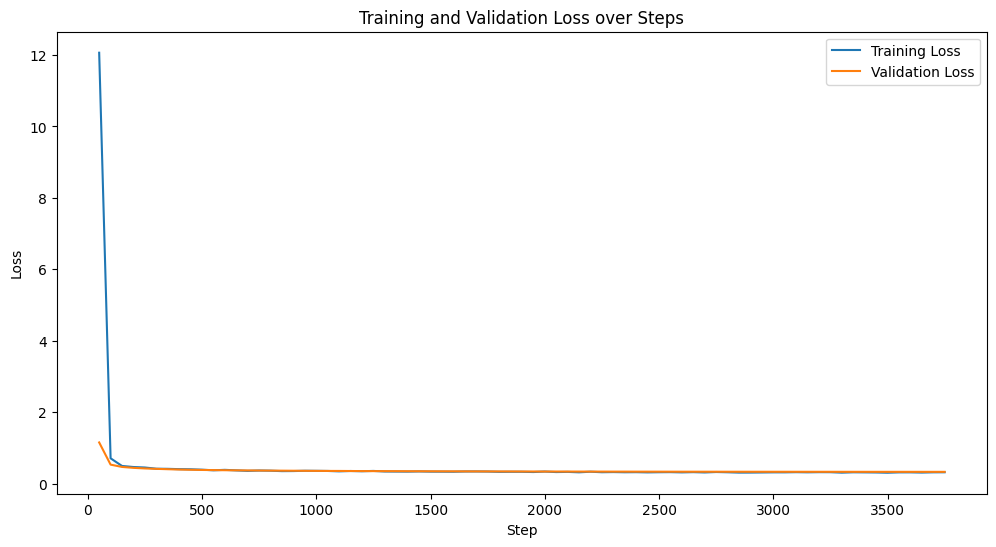

In [27]:
steps = sorted(set(log['step'] for log in log_history if 'step' in log))
losses = [log['loss'] for log in log_history if 'loss' in log]
val_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Steps')
plt.savefig(PATH_RESULTS+"loss_curves.png", format='png')
plt.show()

In [28]:
transformers_logging.set_verbosity_error()
model_name = PATH_MODELS+'GPT2chat_single_turn'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50260, bias=False)
)

The MultiWOZ dataset contains mostly factual information about booking a hotel room or travelling between cities, so we will ask our fine-tuned GPT2chat to generate short and deterministic answers.

In [29]:
def chat_with_bot(prompt, previous_chat):
    # Format the input with special tokens
    input_text = f"{previous_chat}[USER] {prompt}[BOT]"

    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

    # Truncate previous chats if input exceeds GPT-2's context limit (1024 tokens for GPT-2 base)
    if input_ids.shape[-1] > 1024:
        input_ids = input_ids[:, -1024:]  # Keep only the last 1024 tokens

    # Generate the bot's response
    output = model.generate(
        input_ids,
        max_new_tokens=20,  
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        pad_token_id=tokenizer.convert_tokens_to_ids('[PAD]'),
        do_sample=False,
    )

    # Decode the output, skipping special tokens
    response = tokenizer.decode(output[:, input_ids.shape[-1] :][0], skip_special_tokens=True)
    
    return response, input_text + response

In [30]:
print("Start chatting with the bot! Type 'exit' to stop.")
previous_chat = ""
count = 0
while True:
    prompt = input("You: ")
    if prompt.lower() == 'exit':
        break
    response, previous_chat = chat_with_bot(prompt, previous_chat)
    cleaned_response = response.replace(prompt, '').strip() if prompt in response else response 
    print(f"GPT2chat: {cleaned_response}")

Start chatting with the bot! Type 'exit' to stop.


You:  Hello


GPT2chat:  I am looking for a train that leaves on Friday.  Where will you be departing from?


You:  London


GPT2chat:  There are many trains leaving on Thursday. What is your destination?  The first train leaves at


You:  Cambridge


GPT2chat:  What time would you like to leave? And what is the price? I need the train ID and


You:  at 5 pm


GPT2chat:  The train id is TR9448 and the cost is 10.10 pounds. Would you also like


You:  exit


Compare the above fine-tuned GPT2chat with the default pre-trained text generator GPT2text (allowing creative texts):

In [31]:
transformers_logging.set_verbosity_error()
tokenizer_pretrained = GPT2Tokenizer.from_pretrained('gpt2')
model_pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
model_pretrained.eval()
model_pretrained.to(device)

def generate_response_pretrained(prompt, model, tokenizer, temperature=0.7):
    inputs = tokenizer_pretrained.encode(prompt, return_tensors="pt").to(device)
    outputs = model_pretrained.generate(
        inputs,
        max_new_tokens=100,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.9,
        temperature=temperature,
    )
    response = tokenizer_pretrained.decode(outputs[0], skip_special_tokens=True)
    return response

In [32]:
while True:
    prompt = input("You: ")
    if prompt.lower() == 'exit':
        break
    response = generate_response_pretrained(prompt, model_pretrained, tokenizer_pretrained)
    print(f"GPT2text: {response}")

You:  Hello


GPT2text: Hello and welcome to the official website of the game.

We are a game company founded in 1999 by our former employees who love to play, learn, and enjoy the experience of playing a video game, but who also want to learn more about video games. We are also a very small company, so we will never be the same. Our goal is to make a great video-game company and we hope you will be proud of us. Thank you for taking the time to read this article!


You:  exit
